In [1]:
# Imports...
import os.path
from os import makedirs
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

# Classical ML.
import torch
from torch.nn import Module
from torch.optim import Adam
from torch import manual_seed
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Quantum ML.
from qiskit_algorithms.utils import algorithm_globals
from qiskit.quantum_info.random import random_statevector
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN

# Version control.
from qiskit import __version__ as qiskit_version
from qiskit_machine_learning import __version__ as qml_version
from qiskit_algorithms import __version__ as alg_version
from torch import __version__ as torch_version

# Plotting.
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

# Scripts.
from scripts.utils import sample_n_states
from scripts.circuits import build_circuit
from scripts.learning import build_qnn_circuit, train_by_scipy, train_by_COBYLA_no_recylcing, train_by_torch

# Styling.
sns.set_context('paper')
sns.set_theme(style='darkgrid', palette='Dark2')

# Device management.
if torch.cuda.is_available(): device = torch.device('cuda')
else: device = torch.device('cpu')

# Random seed setting.
def set_seed(seed):
    if seed is None: return
    
    algorithm_globals.random_seed = seed
    np.random.seed(seed)
    manual_seed(seed)
    
set_seed(42)

# Package versions (ignoring packages that obviously won't be a problem).
print('Important Package Versions...\n')
versions = [('qiskit', qiskit_version), ('qiskit_machine_learning', qml_version), ('qiskit_algorithms', alg_version), ('numpy', np.__version__), ('torch', torch_version)]

pad = max([len(x) for x, _ in versions])
for package, version in versions:
    print(f'{package:<{pad}} : {version}')

Important Package Versions...

qiskit                  : 1.1.1
qiskit_machine_learning : 0.7.2
qiskit_algorithms       : 0.3.0
numpy                   : 1.24.3
torch                   : 2.3.1


# Learning By Depth

We are now more confident that local inversion may be learnt by a variational/QNN approach. The next thing to think about is how well the learning generalises and scales in the complexity of the problem. To that end, we now explore:
- Is the performance of our method is a function of the unknown unitary's depth (i.e. if the loss cannot be brought to zero, then does it increase as a function of unitary depth)?
- What is the relationship between the depth of the ansatz required to reach a particular performance (e.g. loss no greater than 0.1) and the depth of the unknown unitary?
- How does the runtime scale in unitary depth (e.g. when the anstaz depth is kept fixed)?
- How many randomly distributed input samples are required to learn a unitary, and how does it depend on the depth of that unitary?

## Demonstrating the Learning Algorithm

In [2]:
# Sample a unitary to learn and choose the target qubits (to learn the local inversion for).
n, d = 4, 4
U = build_circuit(n=n, d=d)
target_qubits = [1, 2]

# Build a circuit for the QNN from U.
qnn_circuit, input_parameters, weight_parameters = build_qnn_circuit(U, ansatz_reps=3, target_qubits=target_qubits)

# Define a QNN object. 
qnn = SamplerQNN(
    circuit=qnn_circuit,
    input_params=input_parameters,
    weight_params=weight_parameters,
    interpret=lambda x: x, # I'm not actually sure you have to explicitly give an identity interpret.
    output_shape=2, # When specifying an interpret function, output shape cannot be implied, so we must state it.
    input_gradients=True # We must use input gradients to work correctly with PyTorch.
)

# Explicitly declare initial weights (else they will be uniformly randomly sampled from [-1, 1]).
initial_weights = .1 * (2 * algorithm_globals.random.random(qnn.num_weights) - 1)

# Define a PyTorch model from the QNN (and move it to device).
model = TorchConnector(qnn, initial_weights=initial_weights)
model = model.to(device)

In [3]:
# Just out of curiosity, what are we learning?
U.draw()

q_0: ────────────■────■──
          ┌───┐┌─┴─┐  │  
q_1: ──■──┤ X ├┤ X ├──┼──
       │  ├───┤└───┘┌─┴─┐
q_2: ──┼──┤ Z ├─────┤ X ├
     ┌─┴─┐├───┤     └───┘
q_3: ┤ X ├┤ S ├──────────
     └───┘└───┘

In [4]:
# Train and validation sets.
xs_train = sample_n_states(n_states=24, n_qubits=n)
xs_val = sample_n_states(n_states=16, n_qubits=n)

# As DataLoaders.
batch_size = 8
train_loader = DataLoader(xs_train, batch_size=batch_size)
val_loader = DataLoader(xs_val, batch_size=batch_size)

### Optimisation by SciPy methods

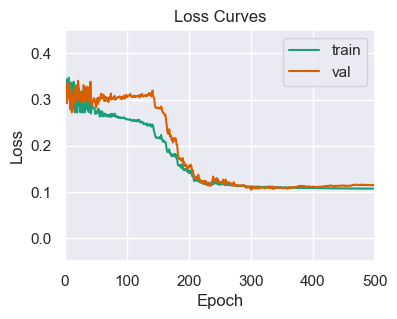

In [5]:
# With recycling (by COBYLA).
_ = train_by_scipy(qnn, xs_train, xs_val, n_epochs=500, initial_weights=initial_weights, live_plot=True)

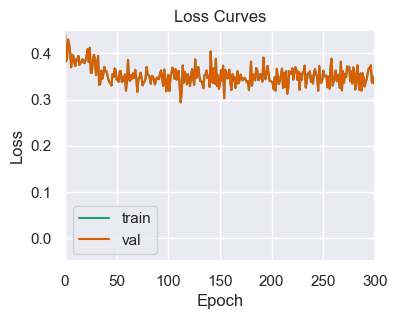

In [47]:
# Without recycling.
_ = train_by_COBYLA_no_recylcing(qnn, batch_size=20, n_epochs=300, initial_weights=initial_weights, live_plot=True)

### Optimisation by PyTorch methods

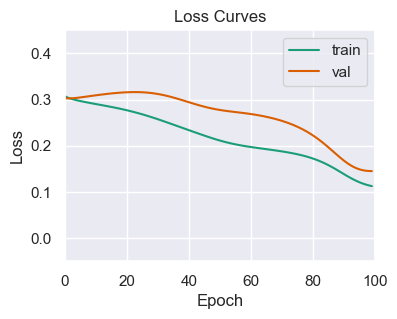

In [7]:
_ = train_by_torch(model, train_loader, val_loader, n_epochs=100, lr=1e-2, live_plot=True)

## Performance by Depth of $U$

At each depth $d$ of $U$, we need to get a sense of how "difficult" the learning task is. This "difficulty" may as well be quantified by how good we can get performance, or how much resource we need to get adequate performance. For now, the way we'll do it is as follows: to quantify how well we can perform at depth $d$, we will observe the average train and validation losses (again, defined by SWAP tests) we get when training a QNN with fixed-depth ansatz for some sufficiently long time (we're not going to wait for full convergence because we're impatient like that) on a set of $d$-deep unknown unitaries $U$. Some preliminary investigation suggests one $U$ per depth $d$ might actually be enough. We might want to try a few different "fixed" depths for the ansatz so that the deeper $U$ are still learnable, but of course we have no idea how $d$ and the depth of the ansatz should be related (yet).

In [9]:
# Reminder about how to incrementally add to a CSV via Pandas.
headers = pd.DataFrame(columns=['id', 'A', 'B', 'C']).set_index('id')
headers.to_csv('./data/test.csv')

new_data = pd.DataFrame({'A': [1], 'B': [2], 'C': [3]})
new_data.to_csv('./data/test.csv', mode='a', header=False)

more_new_data = pd.DataFrame({'A': [10], 'B': [20], 'C': [30]})
more_new_data.to_csv('./data/test.csv', mode='a', header=False)

read_in_data = pd.read_csv('./data/test.csv').set_index('id')
read_in_data

,A,B,C
id,,,
0,1,2,3
0,10,20,30


In [14]:
# Function to evaluate how well we can perform over n_U randomly generated unitaries of depth d, with each depth of ansatz specified in ansatz_reps.
def evaluate_at_depth_by_scipy(n, d, n_U, ansatz_reps, save_path, n_train_samples, n_val_samples, n_epochs, method='COYBLA', verbose=False, overwrite=False, seed=42):
    # Reset seed.
    set_seed(seed)
    
    # Checking given path.
    assert save_path[-4:] == '.csv', 'Save path must be a .csv file extension.'
    
    # Ensure the directory to the save path exists.
    makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # If the save file does not already exist, create it with the appropriate headers.
    if not os.path.exists(save_path) or overwrite: pd.DataFrame(columns=['id', 'Train Loss', 'Val Loss', 'U Depth', 'No. Qubits', 'Ansatz Depth', 'Mean Epoch Runtime', 'Epochs']).set_index('id').to_csv(save_path)
    
    # Evaluating over n_U randomly generated unitaries...
    for _ in (tqdm(range(n_U), desc='Learning local inversions', leave=False) if verbose else range(n_U)):
        # Generate a random unitary.
        U = build_circuit(n=n, d=d, seed=None)
        
        # Arbitrarily choose the target qubits; no need to randomise this choice -- the unitary is already random!
        target_qubits = [1, 2]
        
        # Train and validation sets.
        xs_train = sample_n_states(n_states=n_train_samples, n_qubits=n, seed=None)
        xs_val = sample_n_states(n_states=n_val_samples, n_qubits=n, seed=None)
        
        # And evaluating over the depths in ansatz_reps...
        for reps in (tqdm(ansatz_reps, desc='Trying different ansatz depths', leave=False) if verbose else ansatz_reps):
            # Build a circuit for the QNN from U.
            qnn_circuit, input_parameters, weight_parameters = build_qnn_circuit(U, ansatz_reps=reps, target_qubits=target_qubits, multi_swap=True)
            
            # Define a QNN object. 
            qnn = SamplerQNN(
                circuit=qnn_circuit,
                input_params=input_parameters,
                weight_params=weight_parameters,
                interpret=lambda x: x,
                output_shape=2 ** len(target_qubits), # Multi-qubit SWAP test outputs.
                input_gradients=True
            )
            
            # Explicitly declare initial weights (else they will be uniformly randomly sampled from [-1, 1]).
            initial_weights = .1 * (2 * algorithm_globals.random.random(qnn.num_weights) - 1)
            
            # Train the QNN.
            stats = train_by_scipy(qnn, xs_train, xs_val, n_epochs, initial_weights, method, seed=None)
            
            # Write the stats to the save path.
            pd.DataFrame({
                'Train Loss': [np.min(stats['train_loss'])], 
                'Val Loss': [np.min(stats['val_loss'])], 
                'U Depth': [d], 
                'No. Qubits': [n], 
                'Ansatz Depth': [reps], 
                'Mean Epoch Runtime': [np.mean(stats['runtime'])], 
                'Epochs': [len(stats['train_loss'])]
            }).to_csv(save_path, mode='a', header=False)
            
    # When all is said and done, let's do the final read of the CSV file to give back.
    return pd.read_csv(save_path).set_index('id').reset_index()

In [ ]:
# Testing the function at a depth.       
evaluate_at_depth_by_scipy(n=4, d=4, n_U=10, ansatz_reps=[3, 4, 5], save_path='./data/performance-test.csv', n_train_samples=32, n_val_samples=8, n_epochs=500, verbose=True, overwrite=True)

<Axes: xlabel='Ansatz Depth', ylabel='Mean Epoch Runtime'>

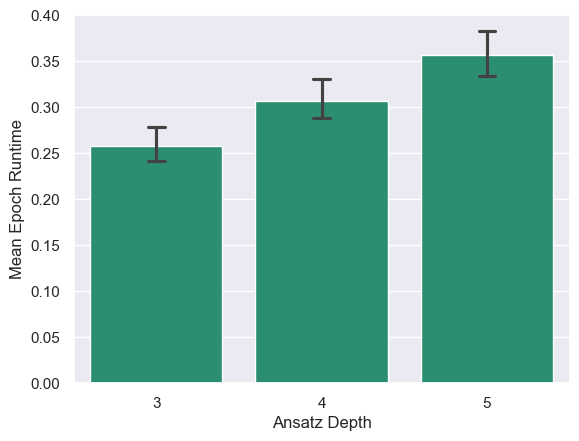

In [53]:
sns.barplot(data=pd.read_csv('./data/performance-test.csv'), x='Ansatz Depth', y='Mean Epoch Runtime', capsize=.1)

In [69]:
# Generate data for a whole bunch of depths of U and ansatz. For reference, this takes ~9 hours 50 minutes.
ds = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
ansatz_reps = [2, 4, 6, 8, 10]
save_path = './data/performance-by-depth-and-reps.csv'

for d in tqdm(ds, desc='Trying different unitary depths'):
    evaluate_at_depth_by_scipy(n=4, d=d, n_U=5, ansatz_reps=ansatz_reps, save_path=save_path, n_train_samples=32, n_val_samples=8, n_epochs=350, verbose=True, overwrite=False)

Trying different unitary depths:   0%|          | 0/10 [00:00<?, ?it/s]

Learning local inversions:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Learning local inversions:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Learning local inversions:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Learning local inversions:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Learning local inversions:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Learning local inversions:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Learning local inversions:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Learning local inversions:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Learning local inversions:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Learning local inversions:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
# Read in all that data.
data = pd.read_csv('./data/performance-by-depth-and-reps.csv').set_index('id').reset_index(drop=True)
data

,Train Loss,Val Loss,U Depth,No. Qubits,Ansatz Depth,Mean Epoch Runtime,Epochs
0,0.089837,0.197398,2,4,2,0.192424,350
1,0.011411,0.008532,2,4,4,0.282384,350
2,0.098840,0.212618,2,4,6,0.371384,350
3,0.171226,0.181511,2,4,8,0.476403,350
4,0.107936,0.146511,2,4,10,0.566305,350
...,...,...,...,...,...,...,...
245,0.299161,0.331874,20,4,2,0.283701,350
246,0.050987,0.051640,20,4,4,0.370157,350
247,0.176617,0.234492,20,4,6,0.456083,350
248,0.217321,0.237358,20,4,8,0.543002,350


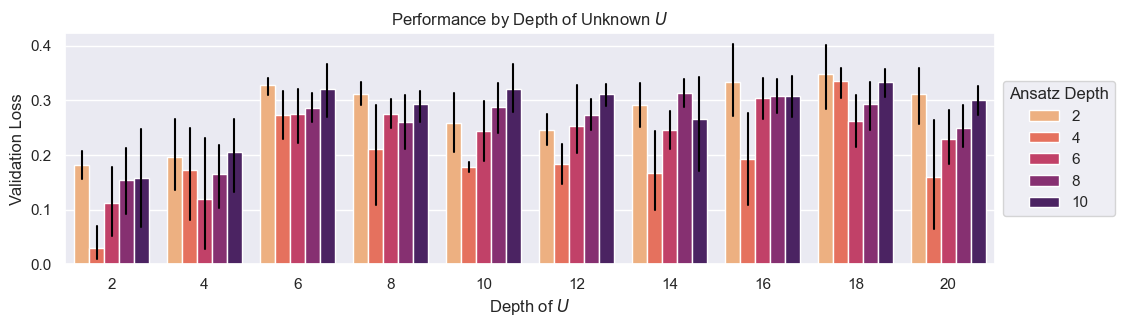

In [125]:
# Loss by depth of U (hue on ansatz depth).
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

# Plot.
sns.barplot(data=data, x='U Depth', y='Val Loss', hue='Ansatz Depth', saturation=1, palette='flare', err_kws={'color': 'k', 'linewidth': 1.5}, ax=ax)

# Beautification.
ax.set_title('Performance by Depth of Unknown $U$')
ax.set_xlabel('Depth of $U$')
ax.set_ylabel('Validation Loss')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Ansatz Depth')

plt.savefig('./figures/performance-by-depth-bar-plot.pdf', bbox_inches='tight')

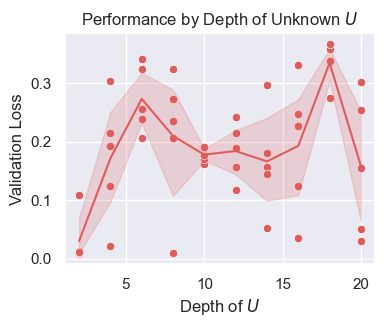

In [126]:
# Closer look at Ansatz depth 4.
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

# Plot.
color = sns.color_palette('flare', n_colors=data['Ansatz Depth'].nunique())[1]
sns.scatterplot(data=data[data['Ansatz Depth'] == 4], x='U Depth', y='Val Loss', color=color, ax=ax)
sns.lineplot(data=data[data['Ansatz Depth'] == 4], x='U Depth', y='Val Loss', color=color, ax=ax)

# Beautification.
ax.set_title('Performance by Depth of Unknown $U$')
ax.set_xlabel('Depth of $U$')
ax.set_ylabel('Validation Loss')

plt.savefig('./figures/performance-by-depth-(ansatz=4).pdf', bbox_inches='tight')

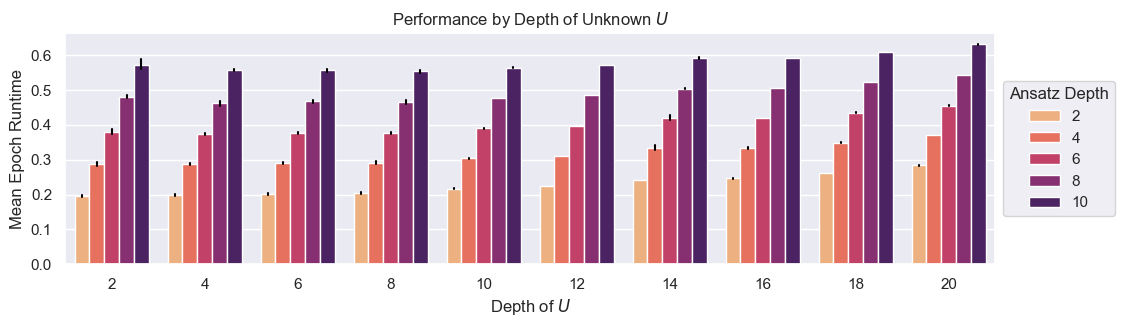

In [9]:
# Looking at runtime.
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

# Plot.
sns.barplot(data=data, x='U Depth', y='Mean Epoch Runtime', hue='Ansatz Depth', saturation=1, palette='flare', err_kws={'color': 'k', 'linewidth': 1.5}, ax=ax)

# Beautification.
ax.set_title('Performance by Depth of Unknown $U$')
ax.set_xlabel('Depth of $U$')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Ansatz Depth')


In [16]:
# Re-running the experiments, but a hell of a lot more of them, for ansatz depth 4 only. For reference, this took ~15 hours
ds = np.arange(start=2, stop=22, step=2)
ansatz_reps = [4]
save_path = './data/performance-by-depth-(reps=4).csv'

for d in tqdm(ds, desc='Trying different unitary depths'):
    evaluate_at_depth_by_scipy(n=4, d=d, n_U=20, ansatz_reps=ansatz_reps, save_path=save_path, n_train_samples=24, n_val_samples=8, n_epochs=1000, verbose=True, overwrite=False)

Trying different unitary depths:   0%|          | 0/10 [00:00<?, ?it/s]

Learning local inversions:   0%|          | 0/20 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Learning local inversions:   0%|          | 0/20 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Learning local inversions:   0%|          | 0/20 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Learning local inversions:   0%|          | 0/20 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Learning local inversions:   0%|          | 0/20 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Learning local inversions:   0%|          | 0/20 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Learning local inversions:   0%|          | 0/20 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Learning local inversions:   0%|          | 0/20 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Learning local inversions:   0%|          | 0/20 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Learning local inversions:   0%|          | 0/20 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
# Re-running the experiments, but a hell of a lot more of them, for ansatz depth 4 only. For reference, this took ~9.5 hours.
ds = np.arange(start=22, stop=32, step=2)
ansatz_reps = [4]
save_path = './data/performance-by-depth-(reps=4).csv'

for d in tqdm(ds, desc='Trying different unitary depths'):
    evaluate_at_depth_by_scipy(n=4, d=d, n_U=20, ansatz_reps=ansatz_reps, save_path=save_path, n_train_samples=24, n_val_samples=8, n_epochs=1000, verbose=True, overwrite=False)

Trying different unitary depths:   0%|          | 0/5 [00:00<?, ?it/s]

Learning local inversions:   0%|          | 0/20 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Learning local inversions:   0%|          | 0/20 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Learning local inversions:   0%|          | 0/20 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Learning local inversions:   0%|          | 0/20 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Learning local inversions:   0%|          | 0/20 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

Trying different ansatz depths:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# Read it in.
data = pd.read_csv('./data/performance-by-depth-(reps=4).csv').set_index('id').reset_index(drop=True)
data

,Train Loss,Val Loss,U Depth,No. Qubits,Ansatz Depth,Mean Epoch Runtime,Epochs
0,3.608164e-08,4.370402e-08,2,4,4,0.239432,1000
1,1.880477e-01,2.525210e-01,2,4,4,0.237114,1000
2,1.304856e-01,7.246023e-02,2,4,4,0.240396,1000
3,4.342842e-09,4.553962e-09,2,4,4,0.234920,1000
4,4.034374e-07,5.129255e-07,2,4,4,0.238408,1000
...,...,...,...,...,...,...,...
295,1.012367e-01,1.225225e-01,30,4,4,0.366332,1000
296,2.555556e-01,3.186334e-01,30,4,4,0.371503,1000
297,2.020359e-01,2.367696e-01,30,4,4,0.370329,1000
298,2.010110e-01,2.939026e-01,30,4,4,0.373858,1000


C:\Users\bwpri\AppData\Local\Temp\ipykernel_2420\1473065232.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='U Depth', y='Val Loss', saturation=1, palette='flare', ax=ax)


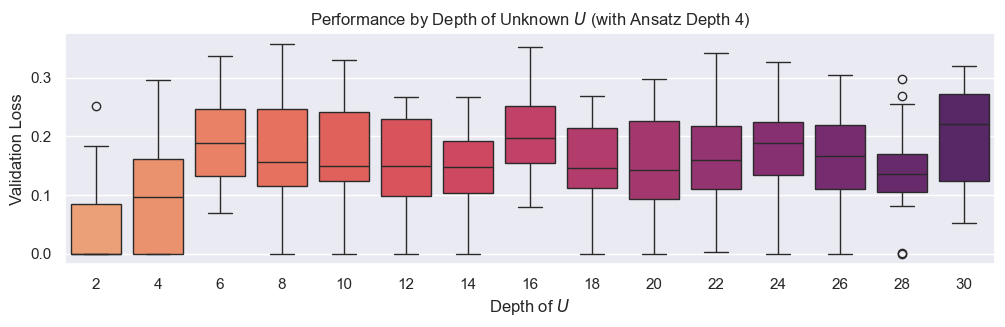

In [28]:
# Loss by depth of U (hue on ansatz depth).
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

# Plot.
sns.boxplot(data=data, x='U Depth', y='Val Loss', saturation=1, palette='flare', ax=ax)

# Beautification.
ax.set_title('Performance by Depth of Unknown $U$ (with Ansatz Depth 4)')
ax.set_xlabel('Depth of $U$')
ax.set_ylabel('Validation Loss')

plt.savefig('./figures/performance-by-depth-box-plot-(reps=4).pdf', bbox_inches='tight')

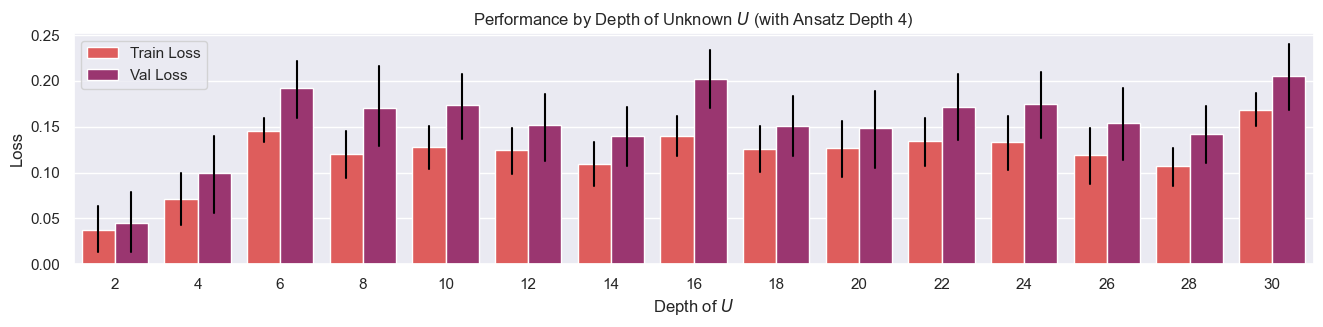

In [34]:
# Loss by depth of U (hue on ansatz depth).
fig, ax = plt.subplots(1, 1, figsize=(16, 3))

# Plot.
sns.barplot(data=data.melt(id_vars='U Depth', value_vars=['Train Loss', 'Val Loss']), x='U Depth', y='value', hue='variable', saturation=1, palette='flare', err_kws={'color': 'k', 'linewidth': 1.5}, ax=ax)

# Beautification.
ax.set_title('Performance by Depth of Unknown $U$ (with Ansatz Depth 4)')
ax.set_xlabel('Depth of $U$')
ax.set_ylabel('Loss')
ax.legend()

plt.savefig('./figures/performance-by-depth-bar-plot-(reps=4).pdf', bbox_inches='tight')

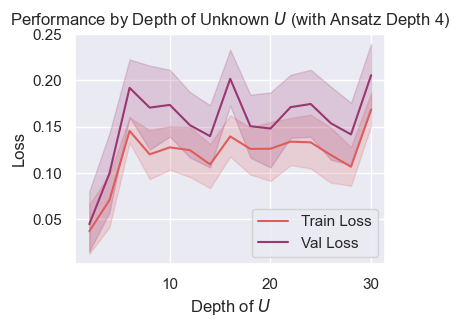

In [35]:
# Loss by depth of U (hue on ansatz depth).
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

# Plot.
sns.lineplot(data=data.melt(id_vars='U Depth', value_vars=['Train Loss', 'Val Loss']), x='U Depth', y='value', hue='variable', palette='flare', ax=ax)

# Beautification.
ax.set_title('Performance by Depth of Unknown $U$ (with Ansatz Depth 4)')
ax.set_xlabel('Depth of $U$')
ax.set_ylabel('Loss')
ax.legend()

In [56]:
[data[data['U Depth'] == i]['Val Loss'].mean() for i in data['U Depth'].unique()]

[0.04494879069767037,
 0.09972441831860754,
 0.19202330656613822,
 0.17072580578580704,
 0.17366119208927083,
 0.151746689383952,
 0.13990479571816303,
 0.20182005298230804,
 0.1507327162583812,
 0.14810978031605285,
 0.17122107000110656,
 0.17464811979654588,
 0.15384912429762868,
 0.14179829774136304,
 0.2056994503781394]

Text(0, 0.5, 'Val Loss')

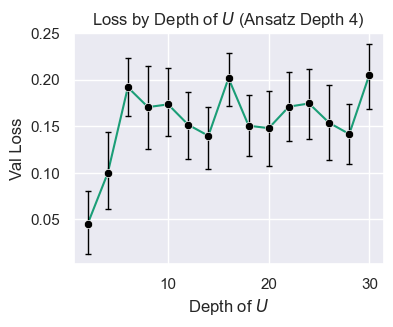

In [78]:
# Loss by depth of U (hue on ansatz depth).
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

# Plot.
sns.lineplot(data=data, x='U Depth', y='Val Loss', err_style='bars', errorbar='ci', err_kws={'ecolor': 'k', 'linewidth': 1, 'capsize': 2}, ax=ax)
sns.scatterplot(x=data['U Depth'].unique(), y=[data[data['U Depth'] == i]['Val Loss'].mean() for i in data['U Depth'].unique()], color='k', zorder=10, ax=ax)

# Beautification.
ax.set_title('Loss by Depth of $U$ (Ansatz Depth 4)')
ax.set_xlabel('Depth of $U$')
ax.set_ylabel('Val Loss')